## Import libraries

In [1]:
# !pip install easydev

### Extracting Colors

In [2]:
import extcolors
import pandas as pd
from colormap import rgb2hex
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
def identify_color_composition(image,
                               tolerance: int = 12,
                               limit: int = 1,
                               visualize: bool = False) -> None:
    """Function that identifies the color composition of a
    given image path."""

    extracted_colors = extcolors.extract_from_path(
        image, tolerance=tolerance, limit=limit)

    identified_colors = color_to_df(extracted_colors)

    if not visualize:
        return identified_colors

    list_color = list(identified_colors['c_code'])
    list_percent = [int(i) for i in list(identified_colors['occurrence'])]

    text_c = [c + ' ' + str(round(p*100/sum(list_percent), 1)) + '%' for c, p in zip(list_color,
                                                                                     list_percent)]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100), dpi=10)
    wedges, _ = ax[0].pie(list_percent,
                          labels=text_c,
                          labeldistance=1.05,
                          colors=list_color,
                          textprops={'fontsize': 60, 'color': 'black'}
                          )

    plt.setp(wedges, width=0.3)

    # create space in the center
    plt.setp(wedges, width=0.36)

    ax[0].set_aspect("equal")
    fig.set_facecolor('grey')

    ax[1].imshow(Image.open(image))

    plt.show()

    return identified_colors


def color_to_df(extracted_colors: tuple):
    """Converts RGB Color values from extcolors output to HEX Values."""

    colors_pre_list = str(extracted_colors).replace(
        '([(', '').replace(')],', '), (').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')', '')
                  for i in colors_pre_list]

    # convert RGB to HEX code
    df_rgb_values = [(int(i.split(", ")[0].replace("(", "")),
                      int(i.split(", ")[1]),
                      int(i.split(", ")[2].replace(")", ""))) for i in df_rgb]

    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(", "")),
                           int(i.split(", ")[1]),
                           int(i.split(", ")[2].replace(")", ""))) for i in df_rgb]

    colors_df = pd.DataFrame(zip(df_color_up, df_rgb_values, df_percent),
                             columns=['c_code', 'rgb', 'occurrence'])

    return colors_df


In [4]:
import pytesseract
import cv2
import numpy as np
from typing import List, Tuple

In [5]:
def convert_hex_to_rgb(hex_color: str, normalize: bool = True) -> List[str]:
    """Converts a HEX color to a RGB color

    Args:
        hex_color (str): HEX color code to convert
        normalize (bool, optional): Choice to normalize calculated rgb values . Defaults to True.

    Returns:
        List[str]: List of RGB values in order, normalized or not.
    """
    colors = hex_color[1:]

    # Convert HEX color values to RGB Values
    colors = [int(colors[0:2], base=16),  # RED
              int(colors[2:4], base=16),  # GREEN
              int(colors[4:6], base=16)]  # BLUE

    # Normalize RGB values
    if normalize:
        colors = [color / 255 for color in colors]

    return colors

def get_luminance(hex_color: str) -> float:
    """Calculates the luminance of a given HEX color

    Args:
        hex_color (str): HEX color code to calculate luminance for

    Returns:
        float: luminance value of color
    """
    colors = convert_hex_to_rgb(hex_color)

    luminance = colors[0] * 0.2126 + colors[1] * 0.7152 + colors[2] * 0.0722

    return luminance

def fix_image_background(image_path: str):
    identified_colors = identify_color_composition(image_path)
    text_color = identified_colors['c_code'].to_list()[0]
    text_color_rgb = identified_colors['rgb'].to_list()[0]
    luminance = get_luminance(hex_color=text_color)

    if luminance < 140:
        background_color = (255, 255, 255)
    else:
        background_color = (0, 0, 0)

    # Load image
    image = cv2.imread(image_path)

    # Make all perfectly green pixels white
    image[np.all(image != text_color_rgb, axis=-1)] = background_color

    return image

def extract_text(image_path, tesseract_cmd: str, fix_background: bool = False):
    pytesseract.pytesseract.tesseract_cmd = tesseract_cmd
    try:
        if fix_background:
            text = pytesseract.image_to_string(
                fix_image_background(image_path))
        else:
            text = pytesseract.image_to_string(image_path)

        return text

    except pytesseract.TesseractNotFoundError:
        raise Exception(
            f'Failure: Tesseract is not installed or not available in the defined path {tesseract_cmd}')

In [8]:
ext_str = extract_text('./extracted/bfbf7a2b7ac635e67877b1ab87fd6629-b7a604b3b08f0862ef0e_start_frame.png',
             r'/usr/bin/tesseract')

In [12]:
ext_str = ext_str.lower()
ext_str.find('tap')

-1

In [ ]:
def preprocess_first(tweets):
    # Remove the stop words to prepare the word clouds
    stopWords = set(STOPWORDS)
    
    # Regex patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    

    # remove stop words
    tweets = tweets.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopWords))    
    # remove @username 
    tweets = tweets.apply(lambda words: ' '.join(re.sub(urlPattern,' ',word) for word in words.split() ))
    # remove all urls 
    tweets = tweets.apply(lambda words: ' '.join(re.sub(userPattern,' ', word) for word in words.split() ))
    # Replace 3 or more consecutive letters by 2 letter.
    tweets = tweets.str.replace('[^a-zA-Z\s]', ' ')
    #     /^[a-zA-Z\s]*$/g
    tweets = tweets.apply(lambda words: ' '.join(re.sub(sequencePattern, seqReplacePattern, word) for word in words.split() ))
    # remove characters and non-english letters
    
    
    return tweets

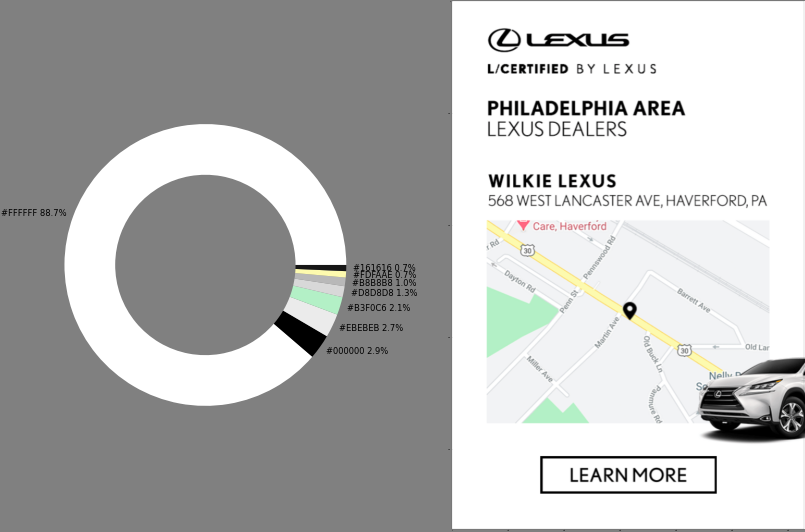

,c_code,rgb,occurrence
0,#FFFFFF,"(255, 255, 255)",502680
1,#000000,"(0, 0, 0)",16156
2,#EBEBEB,"(235, 235, 235)",15391
3,#B3F0C6,"(179, 240, 198)",11626
4,#D8D8D8,"(216, 216, 216)",7149
5,#B8B8B8,"(184, 184, 184)",5583
6,#FDFAAE,"(253, 250, 174)",4101
7,#161616,"(22, 22, 22)",3976


In [28]:
identify_color_composition('./extracted/bfbf7a2b7ac635e67877b1ab87fd6629-b7a604b3b08f0862ef0e_end_frame2.png',tolerance=5,limit=8, visualize=True)

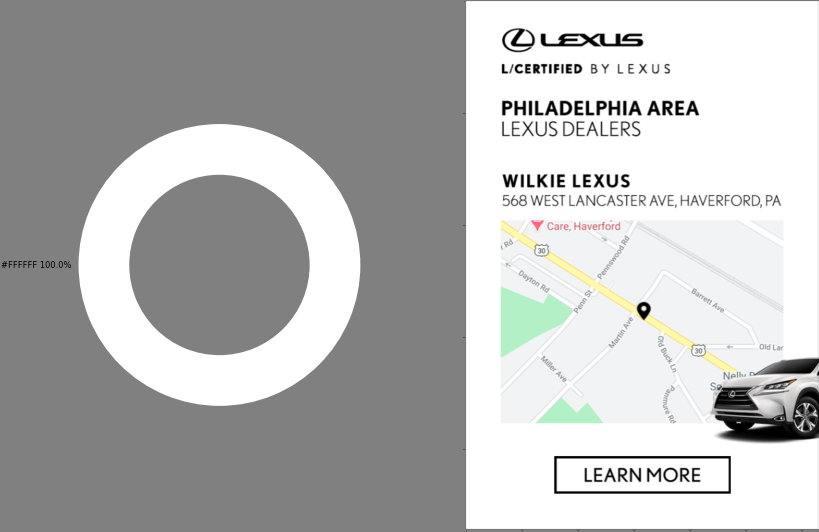

,c_code,rgb,occurrence
0,#FFFFFF,"(255, 255, 255)",519118


In [30]:
identify_color_composition(
    './extracted/bfbf7a2b7ac635e67877b1ab87fd6629-b7a604b3b08f0862ef0e_end_frame2.png', visualize=True)

In [31]:
fix_image_background('./extracted/bfbf7a2b7ac635e67877b1ab87fd6629-b7a604b3b08f0862ef0e_end_frame2.png')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

## Detect logos